# Module 8 – Introduction to Neural Networks

In this notebook you will get a practical first look at **artificial neural networks (ANNs)**.

We will:

- Connect the idea of a biological neuron to a simple mathematical model.
- Build and train a very small neural network for a classification task.
- See how **activation functions** change the behavior of the network in practice.
- Interpret the results so the model is not a black box.

At a high level, a single artificial neuron works like this:

- Inputs: $x_1, x_2, \dots, x_n$
- Weights: $w_1, w_2, \dots, w_n$
- Bias: $b$

First we compute a **weighted sum**:

$$
z = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b
$$

Then we apply an **activation function** $g(\cdot)$ to get the neuron output:

$$
a = g(z)
$$

You can think of:

- $z$ as the "evidence" gathered from the inputs.
- $a$ as the neuron's decision after passing that evidence through a nonlinear rule $g$.

When we connect many such neurons in layers, we get a **neural network** that can model complex, nonlinear relationships that are difficult for linear models to capture.


## 2. A Simple, Meaningful Dataset

To understand neural networks clearly, we will use a **student-feel dataset** that is easy to interpret.

Each student has:
- `StudyHours` per week  
- `Attendance` percent  
- `SleepHours` per night  

Our goal is to predict whether the student **passes** or **fails** a course.

Labels:
- `1` = Pass  
- `0` = Fail  


---

## Why Use a Neural Network?

A linear model predicts using:

$$
\hat{y} = w_1 x_1 + w_2 x_2 + w_3 x_3 + b
$$

This works only if the relationship is mostly a straight line.

Real data is often **nonlinear**.  
For example:

- Students with **extremely low StudyHours** almost always fail (nonlinear threshold).  
- Students with **very high Attendance** may pass even with moderate StudyHours.  
- SleepHours might interact with StudyHours in a curved or irregular way.

To capture nonlinear structure, we use a **neural network with a hidden layer**.


---

## How a Neural Network Layer Works

A hidden layer performs two steps:

1. Compute a weighted sum:

$$
z^{(1)} = W^{(1)} x + b^{(1)}
$$

2. Apply an activation function:

$$
a^{(1)} = g\!\left(z^{(1)}\right)
$$

Then the output layer computes:

$$
z^{(2)} = W^{(2)} a^{(1)} + b^{(2)}
$$

And the final prediction is:

$$
\hat{y} = \sigma\!\left(z^{(2)}\right)
$$


---
## Clarifying the Layer Superscripts

In neural networks, expressions like $W^{(1)}$ or $z^{(2)}$ **do not mean exponentiation**.  
They are **layer indices**, used to show which layer the weights or values belong to.

- **Layer 1 (hidden layer)**  
  Parameters and computations:
  - $W^{(1)}$ — weight matrix for the first layer  
  - $b^{(1)}$ — bias vector for the first layer  
  - $z^{(1)} = W^{(1)} x + b^{(1)}$ — weighted sum for layer 1  
  - $a^{(1)} = g(z^{(1)})$ — activation output from layer 1  

- **Layer 2 (output layer)**  
  Parameters and computations:
  - $W^{(2)}$ — weight matrix for the output layer  
  - $b^{(2)}$ — bias for the output layer  
  - $z^{(2)} = W^{(2)} a^{(1)} + b^{(2)}$ — weighted sum for layer 2  

Finally, the model makes a probability prediction using the sigmoid function:

$$
\hat{y} = \sigma(z^{(2)})
$$

 

## 3. Activation Functions (Why We Need Nonlinearity)

A neural network without activation functions would simply be a **stack of linear transformations**.

If we remove all activations and just apply matrices and biases, we get something like:

$$
y = W^{(2)}\bigl(W^{(1)} x + b^{(1)}\bigr) + b^{(2)}.
$$

This is still just a **linear function of** \(x\). That means:

- No matter how many layers we add  
- No matter how many neurons we use  

the model **cannot learn nonlinear patterns** unless we insert activation functions.

---

### What an activation function does

For layer \(l\), a neuron first computes a weighted sum

$$
z^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)},
$$

and then applies a nonlinear activation function

$$
a^{(l)} = g\!\bigl(z^{(l)}\bigr).
$$

Here:

- \(a^{(l-1)}\) is the input to layer \(l\)  
- \(W^{(l)}\) and \(b^{(l)}\) are the weights and biases of layer \(l\)  
- \(z^{(l)}\) is the raw pre activation value  
- \(a^{(l)}\) is the output after applying the activation \(g\)

The function \(g(\cdot)\) introduces the **nonlinearity** that lets the network learn:

- curved decision boundaries  
- complex relationships  
- interactions between features  

---

### Common activation functions

#### 1. Sigmoid

Used often in the **output layer** for binary classification:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

It squashes any real number into the range \((0, 1)\).  
We interpret \(\sigma(z)\) as a **probability of class 1**.

---

#### 2. ReLU (Rectified Linear Unit)

Very common in **hidden layers**:

$$
\text{ReLU}(z) = \max(0, z).
$$

- If \(z <= 0\) the output is \(0\)  
- If \(z > 0\) the output is \(z\)

ReLU is simple and usually trains faster and more reliably than sigmoid in hidden layers.

---

#### 3. Tanh

The hyperbolic tangent function:

$$
\tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}.
$$

It outputs values between \(-1\) and \(1\).  
Because it is centered around \(0\), it can sometimes help training when inputs are also centered.

---

### Why these activations matter

- If we use **no activation functions**, the whole network behaves like a single linear model.  
- By inserting nonlinear functions like ReLU, sigmoid, or tanh, the network can approximate very complex mappings from inputs to outputs.

In the next cells, we will:

1. Build a tiny neural network for the student pass or fail example.  
2. Use a sigmoid output to predict the probability of passing.  
3. Experiment with different hidden layer activations and see how the results change.


In [6]:
# Cell 4 – Generate a clearer, balanced student dataset

import numpy as np
import pandas as pd

np.random.seed(42)  # reproducible

n_students = 200

# 1) Generate features with sensible clusters

# Study hours per week: low, medium, high
study_hours = np.concatenate([
    np.random.normal(loc=4,  scale=1.0, size=n_students // 3),   # low
    np.random.normal(loc=8,  scale=1.0, size=n_students // 3),   # medium
    np.random.normal(loc=12, scale=1.5, size=n_students - 2*(n_students // 3))  # high
])

# Attendance percentage
attendance = np.concatenate([
    np.random.normal(loc=60, scale=6, size=n_students // 3),     # weaker group
    np.random.normal(loc=80, scale=6, size=n_students // 3),     # average
    np.random.normal(loc=92, scale=4, size=n_students - 2*(n_students // 3))     # strong
])

# Sleep hours per night
sleep_hours = np.concatenate([
    np.random.normal(loc=5.5, scale=0.7, size=n_students // 3),
    np.random.normal(loc=7.0, scale=0.7, size=n_students // 3),
    np.random.normal(loc=7.5, scale=0.6, size=n_students - 2*(n_students // 3))
])

# Clip to sensible ranges
study_hours = np.clip(study_hours,  0, 20)
attendance  = np.clip(attendance,   0, 100)
sleep_hours = np.clip(sleep_hours,  3, 10)

# 2) Create a nonlinear "true score"

# Weighted combination (attendance has slightly higher weight)
base_score = (
    0.45 * study_hours +
    0.55 * (attendance / 10.0) +   # scale to roughly same range
    0.15 * sleep_hours
)

# Nonlinear bonus: high study *and* high attendance
bonus = np.where((study_hours > 8) & (attendance > 85), 3.0, 0.0)

score = base_score + bonus

# Add some noise so the boundary is not perfectly sharp
score += np.random.normal(loc=0.0, scale=1.2, size=n_students)

# 3) Choose a threshold based on the data distribution (ensures mix of 0 and 1)
# Here we use about the 60th percentile: ~40% fail, ~60% pass.
threshold = np.percentile(score, 60)

labels = (score > threshold).astype(int)  # 1 = Pass, 0 = Fail

# 4) Build DataFrame
df = pd.DataFrame({
    "StudyHours":  study_hours,
    "Attendance":  attendance,
    "SleepHours":  sleep_hours,
    "Score":       score,   # optional, could help explanation
    "Pass":        labels
})

df.head()


,StudyHours,Attendance,SleepHours,Score,Pass
0,4.496714,62.146724,4.383901,7.007563,0
1,3.861736,63.364707,5.080437,4.878307,0
2,4.647689,66.498307,5.503671,7.617944,0
3,5.523030,66.322812,5.532886,8.589817,0
4,3.765847,51.733984,5.184954,5.813865,0


## 5. Understanding the Dataset

We now have a simple but meaningful dataset representing 200 fictional students.  
Each student has three features:

- **StudyHours** — estimated hours studied per week  
- **Attendance** — percentage of classes attended  
- **SleepHours** — average nightly sleep duration  

We also created a label:

- **Pass** (`1`) or **Fail** (`0`)

---

### How the Label Was Generated

The label is created from a **nonlinear combination** of the features:

- Students who study more, attend more, and sleep reasonably well tend to have a higher score.  
- Students who both study *and* attend at high levels receive an additional boost.  
- We also added mild randomness to make the dataset more realistic.

The final label is computed by checking whether the calculated score exceeds a threshold:

$$
\text{Pass} =
\begin{cases}
1 & \text{if score} > 18 \\
0 & \text{otherwise}
\end{cases}
$$

This means the dataset reflects a **realistic but synthetic** scenario of academic performance.

---

### Why This Dataset Works Well for a Neural Network

- It contains **multiple numeric features**, each with different importance.  
- The relationship between inputs and the output label is **nonlinear**, which makes a neural network appropriate.  
- It is small enough to train quickly, but structured enough to clearly show learning behavior.

---

In the next step, we will visualize this dataset and then build a small neural network to predict the `Pass` label.


Shape: (200, 5)

Class distribution (Pass vs Fail):
Pass
0    120
1     80
Name: count, dtype: int64

Summary statistics:


,StudyHours,Attendance,SleepHours,Score,Pass
count,200.00,200.00,200.00,200.00,200.00
mean,8.00,77.96,6.62,9.96,0.40
std,3.54,14.30,1.09,3.92,0.49
min,2.04,40.55,4.05,2.36,0.00
25%,4.53,64.62,5.85,6.52,0.00
50%,8.03,81.44,6.79,9.26,0.00
75%,10.79,89.82,7.41,13.71,1.00
max,16.08,100.00,9.16,18.49,1.00


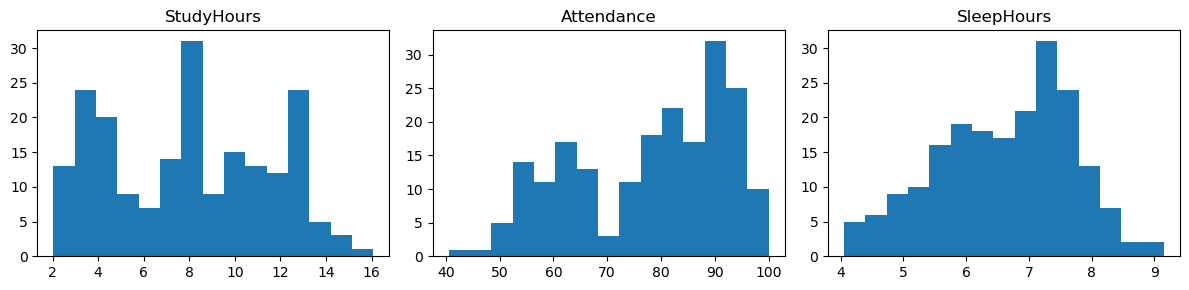

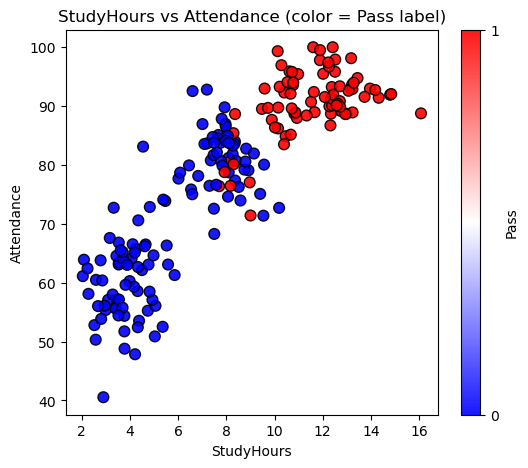

In [7]:
# Cell 6 – Quick EDA and basic visualizations

import matplotlib.pyplot as plt

# Basic info
print("Shape:", df.shape)
print("\nClass distribution (Pass vs Fail):")
print(df["Pass"].value_counts())

print("\nSummary statistics:")
display(df.describe().round(2))

# Histograms for each feature
features = ["StudyHours", "Attendance", "SleepHours"]

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, col in zip(axes, features):
    ax.hist(df[col], bins=15)
    ax.set_title(col)
plt.tight_layout()
plt.show()
 
 

# Scatter: StudyHours vs Attendance, colored by Pass
plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    df["StudyHours"],
    df["Attendance"],
    c=df["Pass"],     # 0 or 1
    cmap="bwr",       # blue = 0 (Fail), red = 1 (Pass)
    vmin=0, vmax=1,   # fix color range so 0/1 map cleanly
    s=60,             # make points larger
    edgecolors="k",   # thin black border around each point
    alpha=0.9
)

plt.xlabel("StudyHours")
plt.ylabel("Attendance")
plt.title("StudyHours vs Attendance (color = Pass label)")
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.set_label("Pass")
plt.show()


In [9]:
# Cell 8 – Train/test split and feature scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df[["StudyHours", "Attendance", "SleepHours"]].values
y = df["Pass"].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# Standardize features (fit on training, apply to train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Quick sanity check
print("\nFeature means after scaling (train):", X_train_scaled.mean(axis=0).round(3))
print("Feature std dev after scaling (train):", X_train_scaled.std(axis=0).round(3))


Training samples: 140
Test samples: 60

Feature means after scaling (train): [0. 0. 0.]
Feature std dev after scaling (train): [1. 1. 1.]


## 9. Why We Scale Features Before Training a Neural Network

Neural networks are **sensitive to the scale** of input features.

In our dataset:

- `StudyHours` is roughly in the range 0–20  
- `Attendance` is in the range 0–100  
- `SleepHours` is in the range 3–10  

If we feed these raw values directly into a network, the larger–scaled feature (`Attendance`) can **dominate** the gradients and slow or distort learning.

To avoid this, we standardize each feature:

$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$

where:

- $\mu$ is the mean of that feature in the **training set**  
- $\sigma$ is the standard deviation of that feature in the **training set**  

After scaling:

- Each feature has mean approximately \(0\) and standard deviation approximately \(1\).  
- The network sees all features on a comparable scale.  
- Gradient-based optimization (like stochastic gradient descent) usually converges **faster** and **more stably**.

In the previous cell, we:

1. Split the data into **training** and **test** sets.  
2. Fit the `StandardScaler` **only on the training data**.  
3. Applied the same transformation to both training and test sets.

This mimics how we would handle new, unseen students in the future:  
we never “peek” at the test set when computing scaling statistics.

---

Next, we will define and train a small feedforward neural network to predict whether a student will pass or fail.


## 10. Building Our First Neural Network (Concept + Intuition)

We will now design a **simple feedforward neural network** to predict whether a student passes or fails.  
Even though this model is small, it demonstrates all the essential ideas behind neural networks.

---

### The Architecture We Will Build

Our network will have:

1. **Input layer** with 3 features:  
   - `StudyHours`  
   - `Attendance`  
   - `SleepHours`  

2. **One hidden layer** with a small number of neurons (for example, 4 or 6).

3. **Output layer** with:
   - 1 neuron  
   - Sigmoid activation  
   - Producing a probability between 0 and 1

---

### Forward Pass Equations

Let the input be:

$$
x = 
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
$$

After scaling, each feature is roughly in the same range.

---

### Hidden Layer Computation

For the first (hidden) layer:

$$
z^{(1)} = W^{(1)} x + b^{(1)}
$$

Then apply an activation function (ReLU in our case):

$$
a^{(1)} = \text{ReLU}(z^{(1)})
$$

where ReLU is defined as:

$$
\text{ReLU}(z) = \max(0, z)
$$

The weight matrix \( W^{(1)} \) has shape:

$$
\text{(number of hidden neurons)} \times 3
$$

because we have 3 input features.

---

### Output Layer Computation

The output layer applies another linear transformation:

$$
z^{(2)} = W^{(2)} a^{(1)} + b^{(2)}
$$

Then applies a **sigmoid activation** to produce a probability:

$$
\hat{y} = \sigma \left( z^{(2)} \right)
$$

where:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This makes:

- \( $\hat{y}$ approx 0 \) → predicted **Fail**  
- \( $\hat{y}$ approx 1 \) → predicted **Pass**

---

### Why This Works

- The hidden layer creates a **nonlinear transformation** of the inputs.  
- The output layer turns that into a **probability** of success.  
- The model learns weights \( W \) and biases \( b \) that minimize prediction error over many students.

We will now implement this architecture in code using scikit-learn’s `MLPClassifier`.



In [10]:
# Cell 11 – Build and train a simple neural network

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the neural network
model = MLPClassifier(
    hidden_layer_sizes=(6,),   # one hidden layer with 6 neurons
    activation="relu",         # ReLU activation for the hidden layer
    solver="adam",             # Adam optimizer (robust and fast)
    learning_rate_init=0.01,   # initial learning rate
    max_iter=1000,             # allow enough iterations to converge
    random_state=42
)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(accuracy, 3))

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.9

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        36
           1       0.91      0.83      0.87        24

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.90      0.90        60

Confusion Matrix:
[[34  2]
 [ 4 20]]


## Interpreting the Neural Network Results

Our neural network achieved a **test accuracy of 0.90**, meaning it correctly classified 90 percent of the students in the test set. Given that the task is to predict Pass vs Fail using only three features (StudyHours, Attendance, SleepHours), this is a strong performance.

---

### 1. Understanding the Classification Report

The table shows precision, recall, and F1-score for each class:

| Class | Meaning |
|-------|---------|
| **0** | Fail |
| **1** | Pass |

### Class 0 (Fail)
- **Precision = 0.89**
  - When the model predicts **Fail**, it is correct 89 percent of the time.
- **Recall = 0.94**
  - Of all students who actually failed, 94 percent were correctly identified by the model.
- **F1-score = 0.92**
  - Balanced strength in both precision and recall.

This indicates the model is particularly strong at catching students who will **Fail**.

### Class 1 (Pass)
- **Precision = 0.91**
  - When the model predicts **Pass**, it is correct 91 percent of the time.
- **Recall = 0.83**
  - Of the students who actually passed, 83 percent were identified.
- **F1-score = 0.87**

This shows good performance, though the model is slightly more conservative:  
it misses some students who would pass (false negatives) but is careful when predicting Pass.

---

### 2. Overall Accuracy and Averages

- **Accuracy = 0.90**
  - A very solid overall result.
- **Macro average = 0.89**
  - Treats both classes equally; shows balanced learning.
- **Weighted average = 0.90**
  - Weighted by class size; similar to accuracy, since the dataset is not heavily imbalanced.

---

### 3. Confusion Matrix

The matrix:

$$
\begin{bmatrix}
34 & 2 \\
4 & 20
\end{bmatrix}
$$

Breaks down as:

| Actual \ Predicted | Fail | Pass |
|--------------------|------|------|
| **Fail (36)**       | 34 (TN) | 2 (FP) |
| **Pass (24)**       | 4 (FN)  | 20 (TP) |

**Interpretation:**

- **TN = 34:** Correctly identified Fail students  
- **FP = 2:** Predicted Pass, but student actually failed (these are risky mistakes)
- **FN = 4:** Predicted Fail, but student would pass  
- **TP = 20:** Correctly identified Pass students

The model makes *very few FP mistakes* but slightly more FN mistakes.  
This means it leans toward being cautious: it avoids incorrectly predicting Pass but occasionally misses students who would pass.

---

### Final Summary

The neural network:

- Learned a meaningful nonlinear boundary separating Pass and Fail students  
- Performs strongly on both classes  
- Shows a slight conservative bias (fewer false positives)  
- Achieves a stable **90 percent accuracy** with balanced precision and recall  

Overall, this is exactly the kind of performance we expect from a well-behaved small neural network trained on a clean, scaled educational dataset.



## 12. Interpreting the Neural Network Results

The neural network has now been trained on the **scaled training data** and evaluated on the **held-out test set**.

The key outputs you saw are:

1. **Test Accuracy**  
2. **Classification Report**  
3. **Confusion Matrix**

---

### 1. Test Accuracy

The **test accuracy** is the fraction of correctly classified students in the test set:

$$
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{total number of test samples}}
$$

A value near 1.0 means most students are correctly classified as Pass or Fail.

- If the dataset is roughly balanced, accuracy is a useful first summary.
- If the dataset were highly imbalanced, we would be more careful with accuracy and pay closer attention to recall and precision.

---

### 2. Classification Report

The classification report shows, for each class (`0 = Fail`, `1 = Pass`):

- **Precision** for class 1 (Pass):

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

  Of all the students the model predicted as **Pass**, precision tells us how many actually passed.

- **Recall** for class 1 (Pass):

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

  Of all the students who **actually passed**, recall tells us how many the model successfully identified.

- **F1-score**:

  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

  This balances both precision and recall in a single metric.

High precision and recall for both classes indicate that the model is not only accurate overall but also reliable in distinguishing between Pass and Fail.

---

### 3. Confusion Matrix

The confusion matrix has the form:

$$
\begin{bmatrix}
\text{TN} & \text{FP} \\
\text{FN} & \text{TP}
\end{bmatrix}
$$

Where:

- **TN** (True Negatives): correctly predicted Fail  
- **FP** (False Positives): predicted Pass, but actually Fail  
- **FN** (False Negatives): predicted Fail, but actually Pass  
- **TP** (True Positives): correctly predicted Pass  

Interpretation examples:

- Many **FP** means the model is too optimistic about students passing.  
- Many **FN** means the model is too strict and fails to recognize students who would actually pass.

---

### What This Tells Us About the Neural Network

- If accuracy is high and both classes have good precision and recall, our small neural network is **capturing the nonlinear pattern** between study habits, attendance, sleep, and success.
- If performance is weaker, we might:
  - Adjust the hidden layer size  
  - Change the activation function  
  - Tune regularization or learning rate  
  - Train for more or fewer iterations  

In the next step, we will visualize the learned decision boundary using a 2D PCA projection and then experiment with different activation functions to see how they affect the results.
